## Training Risk-Aware-VAE

### Load MNIST

In [1]:
import torch
from dataset import read_mnist
from torch.utils.data import DataLoader
from utils import *

torch.manual_seed(2)

In [2]:
mnist_train, mnist_val, mnist_test = read_mnist()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

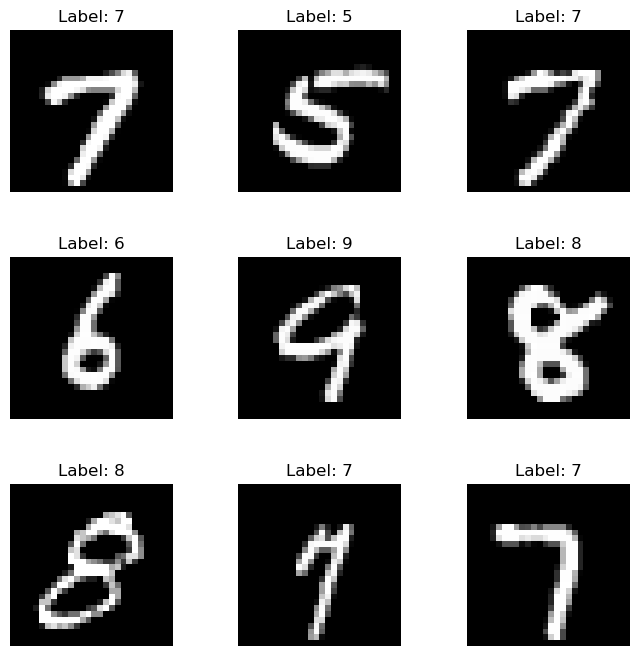

In [3]:
# some visualizations
train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
visualize_dataset_in_grid(train_features, train_labels)

### Train VAE

In [4]:
from train import train_VAE, vanilla_config, two_layer_config

In [5]:
vanilla_config = {"img_size": 28 * 28, 
                  "latent_dim": 2,
                  "layer_config": two_layer_config,
                  "subsample": 100,
                  "device": device,
                  "risk_aware": "neutral",
                  "epochs": 5}

In [6]:
vae_vanilla = train_VAE(vanilla_config, mnist_train, mnist_val)

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:19<00:00, 38.10it/s]


Epoch: 1, train loss: 178.7105, dev loss: 162.4241


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:20<00:00, 36.55it/s]


Epoch: 2, train loss: 158.4079, dev loss: 156.0937


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:20<00:00, 36.20it/s]


Epoch: 3, train loss: 153.9464, dev loss: 153.9627


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.45it/s]


Epoch: 4, train loss: 151.3408, dev loss: 151.2162


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.15it/s]


Epoch: 5, train loss: 149.6263, dev loss: 149.8290


In [7]:
rs_config = {"img_size": 28 * 28, 
             "latent_dim": 2,
             "layer_config": two_layer_config,
             "subsample": 100,
             "device": device,
             "risk_aware": "seeking",
             "epochs": 5}

In [8]:
vae_rs = train_VAE(rs_config, mnist_train, mnist_val)

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


Epoch: 1, train loss: 170.9491, dev loss: 125.3497


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.60it/s]


Epoch: 2, train loss: 153.3275, dev loss: 118.0492


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.71it/s]


Epoch: 3, train loss: 148.6661, dev loss: 114.6401


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.74it/s]


Epoch: 4, train loss: 145.5562, dev loss: 112.3770


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.80it/s]


Epoch: 5, train loss: 143.3127, dev loss: 111.3525


Sanity check

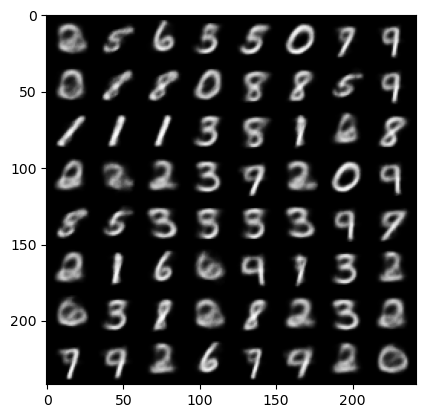

In [9]:
show_gen_img(vae_vanilla, 2, device)

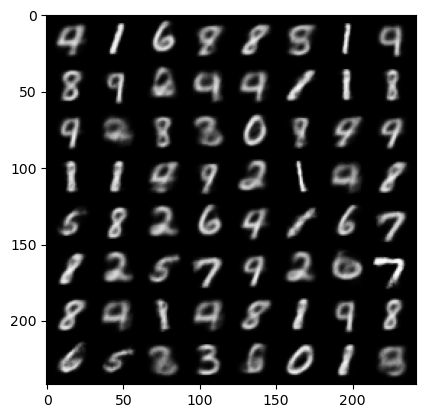

In [10]:
show_gen_img(vae_rs, 2, device)

### Model Evaluation

Preparation

In [11]:
val_dataloader = DataLoader(mnist_val, batch_size=64, shuffle=True)

In [86]:
recon_samples_a, list_recon_loss_a = compute_recon_loss(vae_vanilla, val_dataloader, device)
recon_samples_b, list_recon_loss_b = compute_recon_loss(vae_rs, val_dataloader, device)

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:06<00:00, 29.07it/s]


Image/Sub-sample-wise comparison

Model A: Loss minimum: 26.98318862915039, Loss maximum: 453.0643615722656
Model B: Loss minimum: 25.88332748413086, Loss maximum: 1985.72314453125


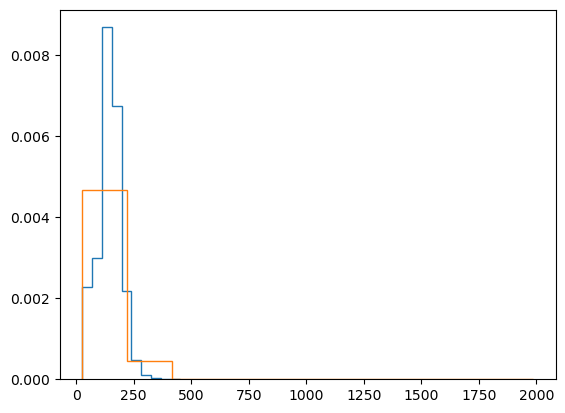

In [138]:
plot_recon_loss(reorder(list_recon_loss_a, by="image"), reorder(list_recon_loss_b, by="image"))

Plot 3 best images

In [147]:
best_imgs_a, best_imgs_loss_a = best_images(recon_samples_a, reorder(list_recon_loss_a, by="image"))
best_imgs_b, best_imgs_loss_b = best_images(recon_samples_b, reorder(list_recon_loss_b, by="image"))

Reconstruction loss: 26.98318862915039
Reconstruction loss: 27.00641441345215
Reconstruction loss: 27.01486587524414
Reconstruction loss: 27.081745147705078
Reconstruction loss: 27.096858978271484
Reconstruction loss: 27.123268127441406
Reconstruction loss: 27.291095733642578
Reconstruction loss: 27.444427490234375
Reconstruction loss: 27.51778221130371
Reconstruction loss: 27.554590225219727
Reconstruction loss: 25.88332748413086
Reconstruction loss: 25.907135009765625
Reconstruction loss: 25.9229736328125
Reconstruction loss: 25.982257843017578
Reconstruction loss: 25.990520477294922
Reconstruction loss: 25.991823196411133
Reconstruction loss: 26.01544952392578
Reconstruction loss: 26.030044555664062
Reconstruction loss: 26.046144485473633
Reconstruction loss: 26.051267623901367


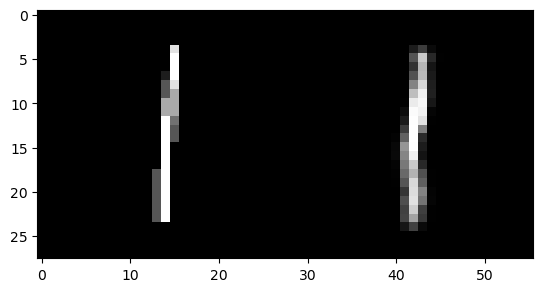

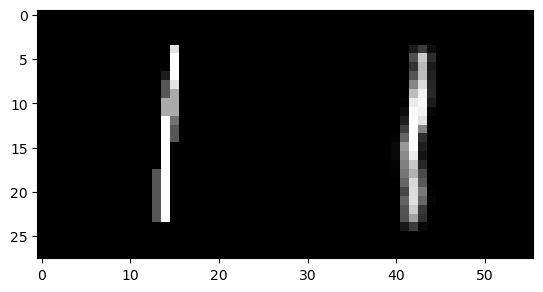

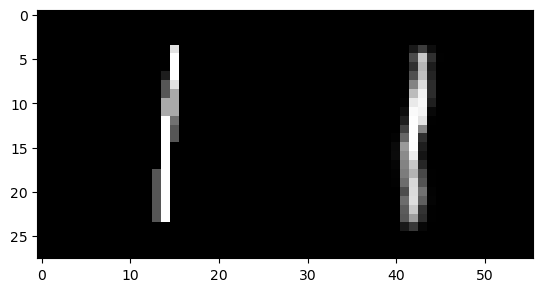

In [148]:
plot_best_images(best_imgs_a)

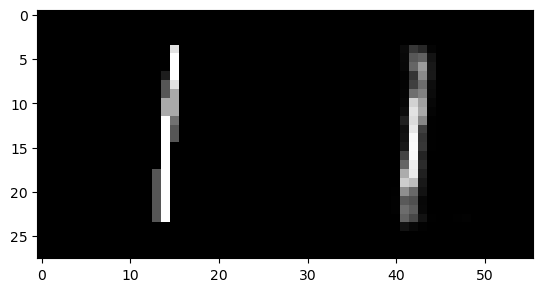

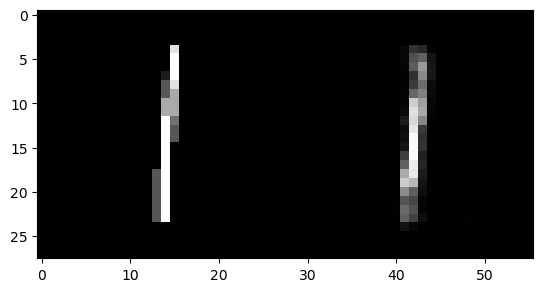

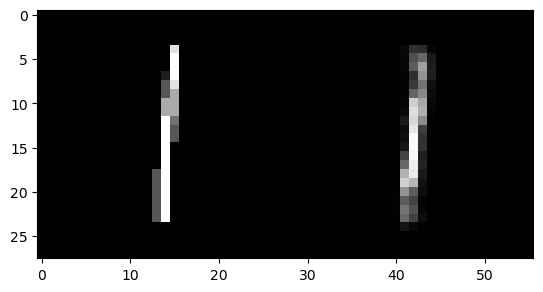

In [149]:
plot_best_images(best_imgs_b)

2 sample t-test for mean reconstruction loss in 10 best images

In [150]:
t_test(best_imgs_loss_a, best_imgs_loss_b)

Significant difference, t-statistics: 16.938433049125436, p-value: 1.6597245580504906e-12


Batch-wise comparison

Model A: Loss minimum: 126.68539428710938, Loss maximum: 160.7013397216797
Model B: Loss minimum: 131.1837615966797, Loss maximum: 166.0723419189453


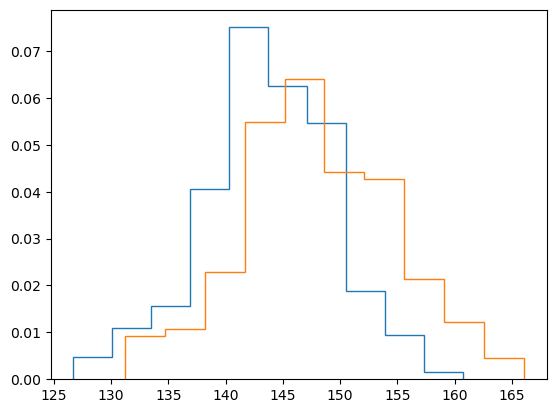

In [139]:
plot_recon_loss(reorder(list_recon_loss_a, by="batch"), reorder(list_recon_loss_b, by="batch"))

Plot images in best batch

In [110]:
best_batch_a, best_batch_loss_a = best_batch(recon_samples_a, reorder(list_recon_loss_a, by="batch"), reorder(list_recon_loss_a, by="image_nested"))
best_batch_b, best_batch_loss_b = best_batch(recon_samples_b, reorder(list_recon_loss_b, by="batch"), reorder(list_recon_loss_b, by="image_nested"))

Loss on best batch: 126.68539428710938
Loss on best batch: 131.1837615966797


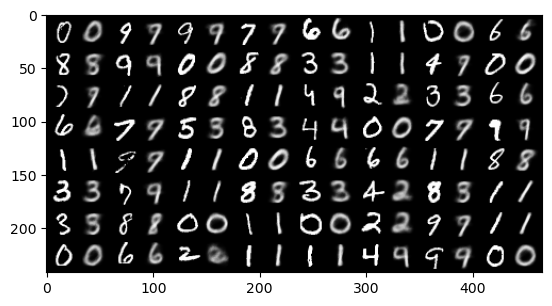

In [111]:
plot_best_batch(best_batch_a)

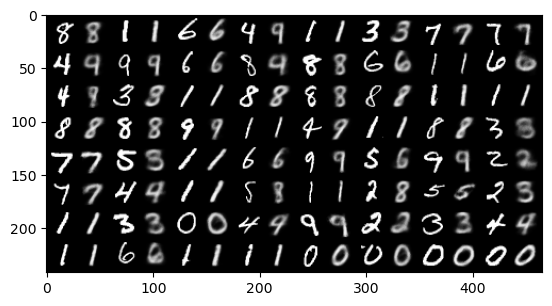

In [112]:
plot_best_batch(best_batch_b)

2 sample t-test for mean reconstruction loss in best batches

In [113]:
t_test(best_batch_loss_a, best_batch_loss_b)

Significant difference, t-statistics: -4.656973251381847, p-value: 3.241203309334141e-06
